In [34]:
import os
import ntpath

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras

import runai.ga

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils.np_utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa

import tensorflow as tf
from tensorflow.python.client import device_lib

import cv2
import pandas as pd
import random

In [35]:
datadir = "lesson14_recording_2"
columns = [ 'center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed' ]
data = pd.read_csv( os.path.join( datadir, 'images.csv' ), names = columns )
data.head()

center  \
0  /home/baudisch/programming/udemy/complete_self...   
1  /home/baudisch/programming/udemy/complete_self...   
2  /home/baudisch/programming/udemy/complete_self...   
3  /home/baudisch/programming/udemy/complete_self...   
4  /home/baudisch/programming/udemy/complete_self...   

                                                left  \
0  /home/baudisch/programming/udemy/complete_self...   
1  /home/baudisch/programming/udemy/complete_self...   
2  /home/baudisch/programming/udemy/complete_self...   
3  /home/baudisch/programming/udemy/complete_self...   
4  /home/baudisch/programming/udemy/complete_self...   

                                               right  steering  throttle  \
0  /home/baudisch/programming/udemy/complete_self...       0.0       1.0   
1  /home/baudisch/programming/udemy/complete_self...       0.0       1.0   
2  /home/baudisch/programming/udemy/complete_self...       0.0       1.0   
3  /home/baudisch/programming/udemy/complete_self...       0.0       1.0   
4  /home/baudisch/programming/udemy/complete_self...       0.0       1.0   

   reverse     speed  
0      0.0  12.76234  
1      0.0  13.37253  
2      0.0  14.22138  
3      0.0  15.02460  
4      0.0  15.40608

In [36]:
def path_leaf( path ):
    head, tail = ntpath.split( path )
    return tail

data[ 'center' ] = data[ 'center' ].apply( path_leaf )
data[ 'left' ] = data[ 'left' ].apply( path_leaf )
data[ 'right' ] = data[ 'right' ].apply( path_leaf )
data.head()

center                              left  \
0  center_2020_11_17_23_36_29_938.jpg  left_2020_11_17_23_36_29_938.jpg   
1  center_2020_11_17_23_36_30_006.jpg  left_2020_11_17_23_36_30_006.jpg   
2  center_2020_11_17_23_36_30_074.jpg  left_2020_11_17_23_36_30_074.jpg   
3  center_2020_11_17_23_36_30_141.jpg  left_2020_11_17_23_36_30_141.jpg   
4  center_2020_11_17_23_36_30_210.jpg  left_2020_11_17_23_36_30_210.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2020_11_17_23_36_29_938.jpg       0.0       1.0      0.0  12.76234  
1  right_2020_11_17_23_36_30_006.jpg       0.0       1.0      0.0  13.37253  
2  right_2020_11_17_23_36_30_074.jpg       0.0       1.0      0.0  14.22138  
3  right_2020_11_17_23_36_30_141.jpg       0.0       1.0      0.0  15.02460  
4  right_2020_11_17_23_36_30_210.jpg       0.0       1.0      0.0  15.40608

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


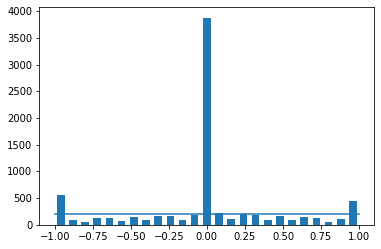

In [37]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram( data[ 'steering' ], num_bins )
center = ( bins[ : -1 ] + bins[ 1: ] ) * 0.5
print( bins )
plt.bar( center, hist, width = 0.05 )
plt.plot( ( np.min( data[ 'steering' ] ), np.max( data[ 'steering' ] ) ), ( samples_per_bin, samples_per_bin ) )

total data:  7677
removed:  4293
remaining:  3384


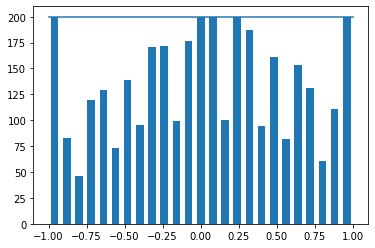

In [38]:
print( 'total data: ', len ( data ) )
remove_list = []
for j in range( num_bins ):
    list_ = []
    for i in range( len ( data[ 'steering' ] ) ):
        if data[ 'steering' ][ i ] >= bins[ j ] and data[ 'steering' ][ i ] <= bins[ j + 1 ]:
            list_.append( i )
    list_ = shuffle( list_ )
    list_ = list_[ samples_per_bin: ]
    remove_list.extend( list_ )

print( 'removed: ', len( remove_list ) )
data.drop( data.index[ remove_list ], inplace = True )
print( 'remaining: ', len( data ) )

hist, _ = np.histogram( data[ 'steering' ], ( num_bins ) )

plt.bar( center, hist, width = 0.05 )
plt.plot( ( np.min( data[ 'steering' ] ), np.max( data[ 'steering' ] ) ), ( samples_per_bin, samples_per_bin ) )

In [39]:
print( data.iloc[ 1 ] )
def load_img_steering( datadir, df ):
    image_path = []
    steering = []
    for i in range( len( data ) ):
        indexed_data = data.iloc[ i ]
        center, left, right = indexed_data[ 0 ], indexed_data[ 1 ], indexed_data[ 2 ]
        image_path.append( os.path.join( datadir, center.strip() ) )
        steering.append( float( indexed_data[ 3 ] ) )
    image_paths = np.asarray( image_path )
    steerings = np.asarray( steering )
    return image_paths, steerings

image_paths, steerings = load_img_steering( datadir + '/IMG', data )

center      center_2020_11_17_23_36_32_084.jpg
left          left_2020_11_17_23_36_32_084.jpg
right        right_2020_11_17_23_36_32_084.jpg
steering                                     0
throttle                              0.399388
reverse                                      0
speed                                   30.056
Name: 30, dtype: object


In [40]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steerings, test_size = 0.2, random_state = 87 )
print( 'Training Samples: {}\nValid Samples: {}'.format( len( X_train ), len( X_valid ) ))

Training Samples: 2707
Valid Samples: 677


Text(0.5, 1.0, 'Training set')

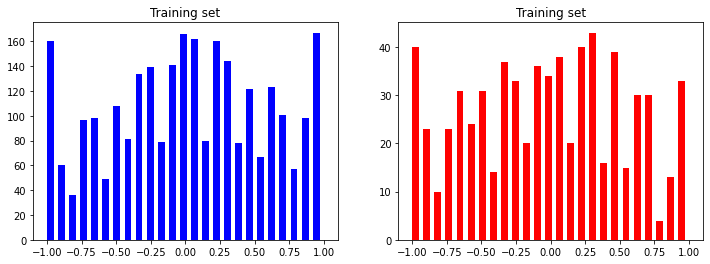

In [41]:
fig, axes = plt.subplots( 1, 2, figsize=( 12, 4 ) )
axes[ 0 ].hist( y_train, bins = num_bins, width = 0.05, color = 'blue' )
axes[ 0 ].set_title('Training set')
axes[ 1 ].hist( y_valid, bins = num_bins, width = 0.05, color = 'red' )
axes[ 1 ].set_title('Training set')

In [42]:
def img_preprocess( img ):
    img = img[ 60:135, :, : ]
    img = cv2.cvtColor( img, cv2.COLOR_RGB2YUV )
    img = cv2.GaussianBlur( img, ( 3, 3 ), 0 )
    img = cv2.resize( img, ( 200, 66 ) )
    img = img / 255
    return img

In [43]:
def img_preprocess_load( img_path ):
    img = mpimg.imread( img_path )
    img = img_preprocess( img )
    return img

(2707, 66, 200, 3)


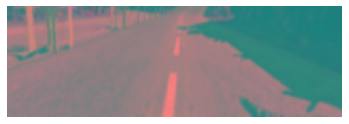

In [44]:
X_train_pp = np.array( list( map( img_preprocess_load, X_train ) ) )
X_valid_pp = np.array( list( map( img_preprocess_load, X_valid ) ) )

plt.imshow( X_train_pp[ random.randint( 0, len( X_train_pp ) - 1 ) ] )
plt.axis( 'off' )
print( X_train_pp.shape )

In [45]:
def zoom( img ):
    zoom = iaa.Affine( scale = ( 1.0, 1.3 ) )
    img_ret = zoom.augment_image( img )
    return img_ret

In [46]:
def pan( img ):
    pan = iaa.Affine( translate_percent = { "x": ( -0.1, 0.1 ), "y": ( -0.1, 0.1 ) } )
    img_ret = pan.augment_image( img )
    return img_ret

In [47]:
def img_rnd_brightness( img ):
    brightness = iaa.Multiply( ( 0.2, 1.2 ) )
    img_ret = brightness.augment_image( img )
    return img_ret

In [48]:
def flip( img, steering_angle ):
    img_ret = cv2.flip( img, 1 )
    return img_ret, (-steering_angle)

In [49]:
def random_augment( image, steering_angle ):
    if np.random.rand() < 0.5:
        image = zoom( image )
    if np.random.rand() < 0.5:
        image = pan( image )
    if np.random.rand() < 0.5:
        image = img_rnd_brightness( image )
    if np.random.rand() < 0.5:
        image, steering_angle = flip( image, steering_angle )
    return image, steering_angle

In [50]:
def random_augment_load( path, steering_angle ):
    image = mpimg.imread( path )
    return random_augment( image, steering_angle )

Text(0.5, 1.0, 'Flipped Image - Steering Angle: 0.5500001')

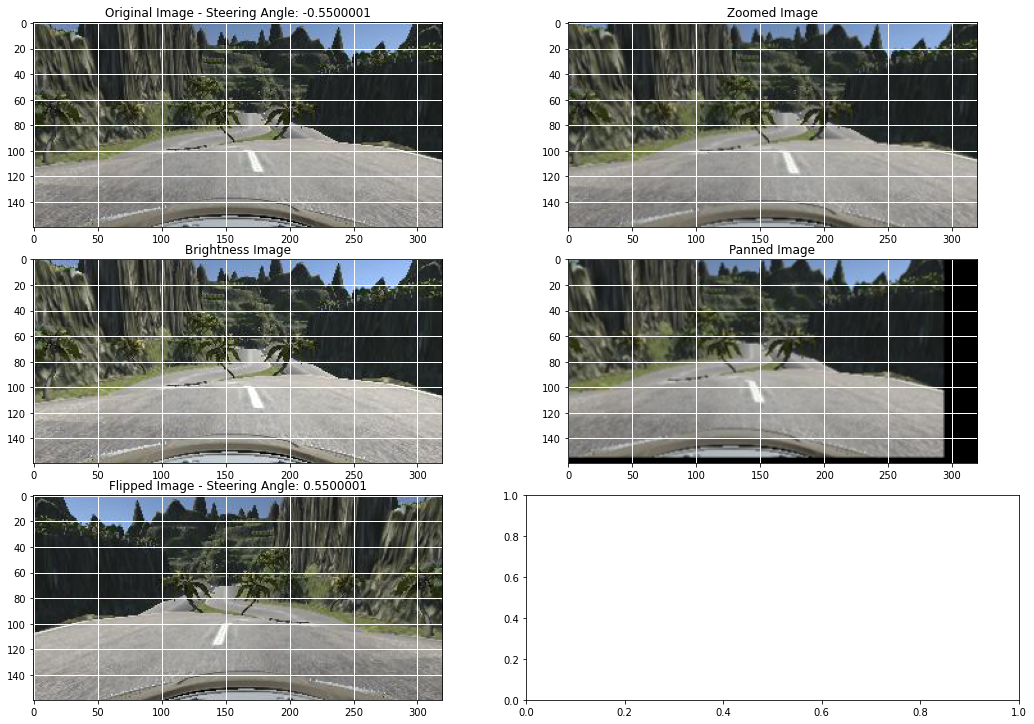

In [51]:
img_idx = random.randint( 0, len( X_train ) - 1 )
img_path = image_paths[ img_idx ]
steering_angle = steerings[ img_idx ]

img_original = mpimg.imread( img_path )
img_zoomed = zoom( img_original )
img_panned = pan( img_original )
img_light = img_rnd_brightness( img_original )
img_flip, steering_angle_flip = flip( img_original, steering_angle )

fig, axs = plt.subplots( 3, 2, figsize = ( 15, 10 ) )
fig.tight_layout()
axs[ 0 ][ 0 ].imshow( img_original )
axs[ 0 ][ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ][ 0 ].set_title( 'Original Image - ' + 'Steering Angle: ' + str( steering_angle ) )
axs[ 0 ][ 1 ].imshow( img_zoomed )
axs[ 0 ][ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ][ 1 ].set_title( 'Zoomed Image' )
axs[ 1 ][ 1 ].imshow( img_panned )
axs[ 1 ][ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ][ 1 ].set_title( 'Panned Image' )
axs[ 1 ][ 0 ].imshow( img_light )
axs[ 1 ][ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ][ 0 ].set_title( 'Brightness Image' )
axs[ 2 ][ 0 ].imshow( img_flip )
axs[ 2 ][ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 2 ][ 0 ].set_title( 'Flipped Image - ' + 'Steering Angle: ' + str( steering_angle_flip ) )

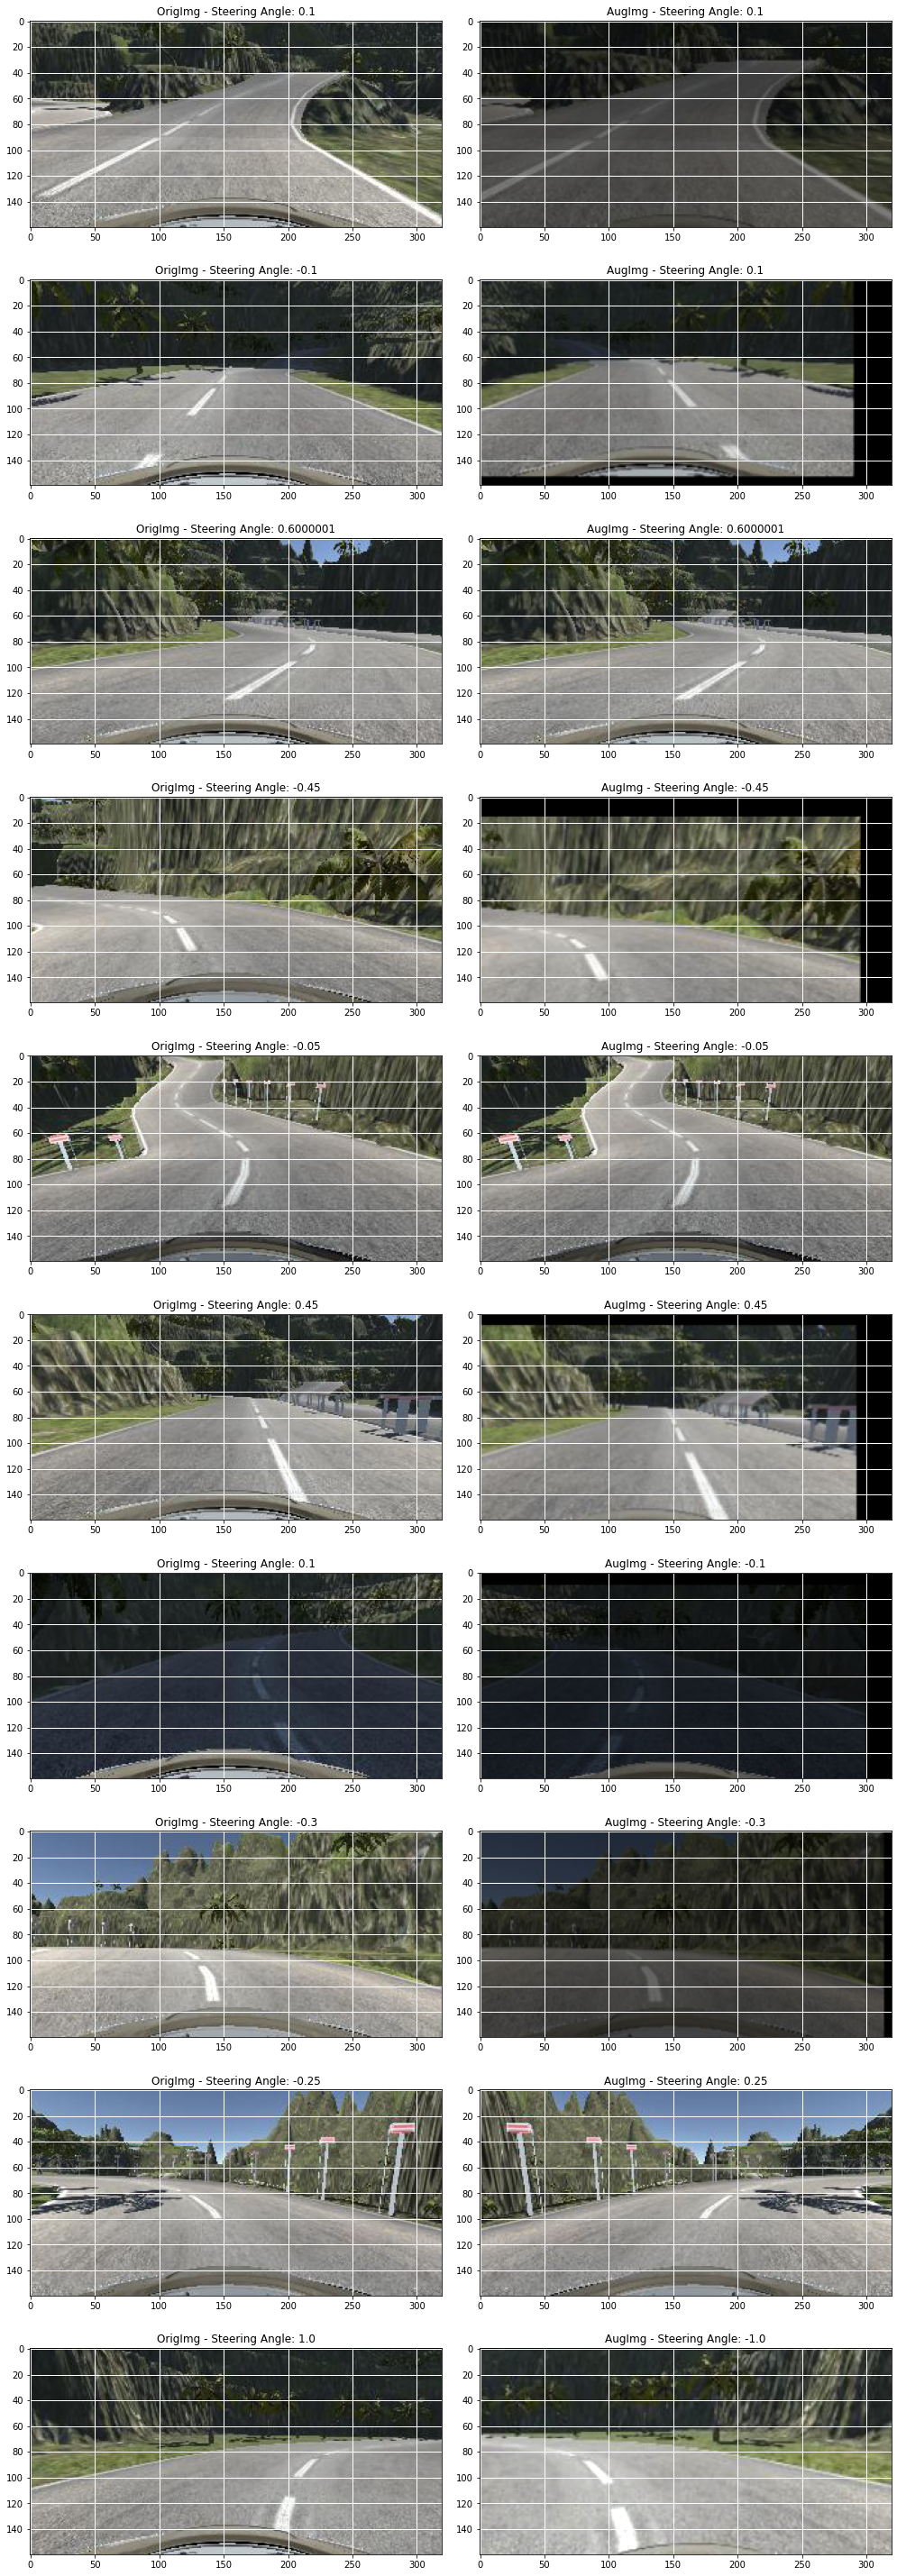

In [52]:
num_imgs = 10
fig, axs = plt.subplots( num_imgs, 2, figsize = ( 14, 40 ) )
fig.tight_layout()

for i in range( 0, num_imgs ):
    img_idx = random.randint( 0, len( X_train ) - 1 )
    img_path = image_paths[ img_idx ]
    steering_angle = steerings[ img_idx ]

    img_original = mpimg.imread( img_path )
    img_augmented, steering_angle_flip = random_augment( img_original, steering_angle )

    axs[ i ][ 0 ].imshow( img_original )
    axs[ i ][ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
    axs[ i ][ 0 ].set_title( 'OrigImg - ' + 'Steering Angle: ' + str( steering_angle ) )
    axs[ i ][ 1 ].imshow( img_augmented )
    axs[ i ][ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
    axs[ i ][ 1 ].set_title( 'AugImg - ' + 'Steering Angle: ' + str( steering_angle_flip ) )

Text(0.5, 1.0, 'Preprocessed Image')

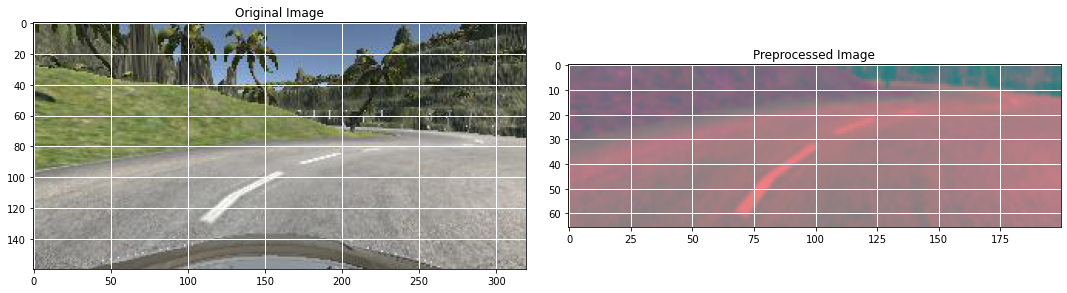

In [53]:
img_path = image_paths[ 100 ]
img_original = mpimg.imread( img_path )
img_preprocessed = img_preprocess( img_original )

fig, axs = plt.subplots( 1, 2, figsize = ( 15, 10 ) )
fig.tight_layout()
axs[ 0 ].imshow( img_original )
axs[ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ].set_title( 'Original Image' )
axs[ 1 ].imshow( img_preprocessed )
axs[ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ].set_title( 'Preprocessed Image' )

In [54]:
#images_list = np.array( list( map( mpimg.imread, image_paths ) ) )
X_train_imgs = np.array( list( map( mpimg.imread, X_train ) ) )
X_valid_imgs = np.array( list( map( mpimg.imread, X_valid ) ) )

In [55]:
def batch_generator_train( images_list, steering_angles, batch_size ):
    #yield
    while True:
        batch_img = []
        batch_steering = []
        for i in range( batch_size ):
            idx = random.randint( 0, len( images_list ) - 1 )

            img, steering = random_augment( images_list[ idx ], steering_angles[ idx ]  )

            img = img_preprocess( img )
            batch_img.append( img )
            batch_steering.append( steering )
        yield ( np.asarray( batch_img ), np.asarray( batch_steering ) )

In [56]:
def batch_generator_valid( images_list, steering_angles, batch_size ):
    #yield
    while True:
        batch_img = []
        batch_steering = []
        for i in range( batch_size ):
            idx = random.randint( 0, len( images_list ) - 1 )

            img = images_list[ idx ]
            steering = steering_angles[ idx ]

            img = img_preprocess( img )
            batch_img.append( img )
            batch_steering.append( steering )
        yield ( np.asarray( batch_img ), np.asarray( batch_steering ) )

Text(0.5, 1.0, 'Validation Image')

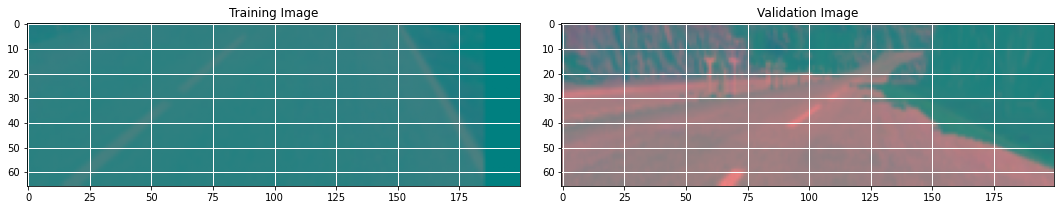

In [57]:
x_train_gen, y_train_gen = next( batch_generator_train( X_train_imgs, y_train, 1 ) )
x_valid_gen, y_valid_gen = next( batch_generator_valid( X_valid_imgs, y_valid, 1 ) )

fig, axs = plt.subplots( 1, 2, figsize = ( 15, 10 ) )
fig.tight_layout()

axs[ 0 ].imshow( x_train_gen[ 0 ] )
axs[ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ].set_title( 'Training Image' )

axs[ 1 ].imshow( x_valid_gen[ 0 ] )
axs[ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ].set_title( 'Validation Image' )

In [58]:
device_lib.list_local_devices()     ## this command list all the processing device GPU and CPU

device_name = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
if device_name[0] == "/device:GPU:0":
    device_name = "/gpu:0"
    print('Using GPU for learning')
else:
    device_name = "/cpu:0"
    print('Using CPU for learning')

Using GPU for learning


In [59]:
with tf.device(device_name):
    def nvidia_model():
        model = Sequential()
        model.add( Convolution2D( 24, 5, 2, input_shape = ( 66, 200, 3 ), activation = 'elu' ) )
        model.add( Convolution2D( 36, 5, 2, activation = 'elu' ) )
        model.add( Convolution2D( 48, 5, 2, activation = 'elu' ) )
        model.add( Convolution2D( 64, 3, activation = 'elu' ) )
        model.add( Convolution2D( 64, 3, activation = 'elu' ) )
        model.add( Dropout( 0.5 ) )

        model.add( Flatten() )
        model.add( Dense( 100, activation = 'elu' ) )
        model.add( Dropout( 0.5 ) )

        model.add( Dense( 50, activation = 'elu' ) )
        model.add( Dropout( 0.5 ) )

        model.add( Dense( 10, activation = 'elu' ) )
        model.add( Dropout( 0.5 ) )

        model.add( Dense(1) )

        optimizer = Adam( lr = 1e-3 )
        #optimizer = runai.ga.keras.optimizers.Optimizer( optimizer, 8 )
        model.compile( optimizer, loss = 'mse' )
        return model

In [60]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [ ]:
#history = model.fit( X_train_flat, y_train_flat, epochs = 20,  validation_data = ( X_val_flat, y_val_flat), batch_size = 400, verbose = 1, shuffle = 1)
#history = model.fit( X_train_pp, y_train, epochs = 30, validation_data = ( X_valid_pp, y_valid ), batch_size = 100, verbose = 1, shuffle = 1 )

history = model.fit(
    batch_generator_train( X_train_imgs, y_train, 100 ),
    steps_per_epoch = 300,
    epochs = 30,
    validation_data = batch_generator_valid( X_valid_imgs, y_valid, 100 ),
    validation_steps = 200,
    verbose = 1,
    shuffle = 1)

Epoch 1/30
300/300 [==============================] - 57s 186ms/step - loss: 0.4317 - val_loss: 0.1751
Epoch 2/30
300/300 [==============================] - 55s 185ms/step - loss: 0.2365 - val_loss: 0.1584
Epoch 3/30
300/300 [==============================] - 55s 183ms/step - loss: 0.2212 - val_loss: 0.1557
Epoch 4/30
300/300 [==============================] - 54s 182ms/step - loss: 0.2197 - val_loss: 0.1447
Epoch 5/30
300/300 [==============================] - 54s 180ms/step - loss: 0.2146 - val_loss: 0.1454
Epoch 6/30
300/300 [==============================] - 55s 183ms/step - loss: 0.2119 - val_loss: 0.1474
Epoch 7/30
300/300 [==============================] - 54s 181ms/step - loss: 0.2075 - val_loss: 0.1504
Epoch 8/30
300/300 [==============================] - 54s 181ms/step - loss: 0.1978 - val_loss: 0.1378
Epoch 9/30
300/300 [==============================] - 54s 181ms/step - loss: 0.1936 - val_loss: 0.1297
Epoch 10/30
300/300 [==============================] - 54s 182ms/step - l

In [ ]:
plt.plot( history.history[ 'loss' ] )
plt.plot( history.history[ 'val_loss' ] )
plt.legend( [ 'training', 'validation' ] )
plt.title( 'Loss' )
plt.xlabel( 'Epoch' )

In [ ]:
model.save( 'model2.h5' )